## 🧪 Genes_primarios_y_secundarios.ipynb

**Autor:** Johanna Atenea Carreon Baltazar  
**Fecha de última modificación:** junio de 2025

**Contacto:** johannaatenea13@gmail.com

---

### 🎯 Objetivo

Clasificar genes duplicados dentro de familias génicas como **primarios** o **secundarios**, utilizando dos enfoques complementarios:

- Un método basado en **umbrales definidos sobre e-value y porcentaje de identidad (pident)**
- El algoritmo **K-means clustering (k = 2)** aplicado sobre las métricas de similitud entre genes

---

### 📥 Entradas requeridas

- `pangenome_matrix_t0.tr.csv`: matriz de presencia/ausencia generada con GET-HOMOLOGUES
- Resultados de BLAST (`*.txt`) con alineamientos entre genes de cada familia
- Carpetas auxiliares:
  - `matrices/`: contiene matrices $n \times n$ de similitud (e-value y pident) por familia
  - `secundarios/`: tablas con medias de e-value y pident por gen duplicado en cada genoma
- Scripts auxiliares:
  - `conteos_por_genoma.sh`
  - `matriz.sh`
  - `resultados_BLAST.sh`

---

### 📤 Salidas generadas

- Clasificación de genes (primarios/secundarios) por familia
- Gráficos y tablas que resumen los criterios de clasificación
- Imágenes de matrices y agrupamientos para familias representativas
- Archivos intermedios en carpetas organizadas por método:
  - `K_means_results/`
  - `clasificación/`

---

### 🧰 Librerías requeridas

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle 
import shutil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## Pipeline

1. Importamos el archivo `pangenome_matrix_t0.tr.csv`el cual se obtuvo con GET-HOMOLOGUES y el comando:

   compare_clusters.pl -o sample_intersection -m -d data_gbks_homologues/Streptococcusagalactiae18RS21prokka_f0_0taxa_algOMCL_e0_

Este archivo es la matriz de presencia ausencia del pangenoma, la cual nos dice que familias estan presentes o ausentes en cada uno de los 29 genomas. Con esta calcularemos en que porcentaje de nuestros 29 genomas esta presente cada familia, de este modo podremos filtrar las familias que estan presentes en al menos el 60% de las familias.

2. Filtramos la matriz de presencia-ausencia para conservar únicamente las familias presentes en al menos el 60% de los genomas (es decir, en al menos 18 de los 29 genomas de cianobacterias). Este filtrado nos deja un total de 3711 familias génicas para el análisis posterior.

3. Con las 3711 familias seleccionadas, utilizamos dos scripts `conteos_por_genoma.sh` y `matriz.sh` ubicados en el directorio: */files/atenea/bacterias/Cianobacterias_corregidas/matriz_abundancia/*. Estos scripts, ejecutados en geomtop, permiten: contar cuántos genes pertenecientes a cada familia están presentes en cada genoma de cianobacterias y generar una matriz de abundancia con los conteos para todos los genomas respectivamente.

4. Con la matriz de abundancia obtenida anteriormente, realizamos un último filtrado para identificar aquellas familias que tienen más de un gen en al menos un genoma, lo cual podría ser indicativo de duplicaciones u otras características relevantes para el análisis. En este paso nos quedan 678 potencias familias.

5. El último filtro para las familias restantes será considerar aquellas familias cuyo output de BLAST las secuencias de consulta sean aproximadamente de longitud mayor a 500 pb, este dato lo podemos consultar en la columna *'lenght'*(cuarta columna) de la salida obtenida con BLAST, la cual nos arroja la longitud en pb de la alineacion entre la secuencia de consulta y la secuencia a comparar.(Este script esta en la ruta: ```/home/atenea/Cianobacterias_corregidas/cortar_primarios_abundancia/resultados_BLAST.sh``` en alnitak.

Despues de seleccionar las familias nos quedamos con 205 familias, pero dado que en el análisis posterior, los outputs de BLAST para cada familia son indispensables y se detectó que al menos para 75 familias existen inconsistencias en estos, al final trabajaremos unicamente con 130 familias.

6. Para las familias restantes, se generarán dos archivos por cada una, los cuales contienen matrices de tamaño $n \times n$ , donde $n$ corresponde al número de genes presentes en la familia. En estas matrices se comparan todas las parejas posibles de genes de la familia, utilizando como métricas el e-value y el porcentaje de identidad (pident).

Estas matrices están almacenadas en la carpeta *matrices/*.

*Ejemplo de matriz de evalues  para la familia 12467_Inner-membrane_proto..*
![](matriz_evalue.png)

7. A partir de las matrices anteriores se construirán tablas auxiliares que servirán para la clasificación posterior de los genes. Estas tablas se encuentran en la carpeta *secundarios/*, y cada tabla lleva el nombre de la familia a la que pertenece. Su estructura es la siguiente:
   
*Ejemplo de tabla de medias para la familia 9892_Periplasmic_aromatic...*

Las filas de la tabla corresponden a genes que provienen de un mismo genoma y que están duplicados dentro de la misma familia, es decir, aquellos genes cuya familia  de la que provienen contiene más de una copia en ese genoma específico, mientras que se tiene dos columnas: *mean_evalue* y *mean_pident* los cuales corresponden a la media del evalue y del pident respectivamente, obtenido al promediar los valores de la fila respectiva del gen en los archivos que almacenan las matrices del paso anterior.

![](familia_media.png)

Con todo lo anterior, propondremos dos métodos para tratar de clasificar los genes como primarios o secundarios:

El primer método consiste en usar **umbrales** para determinar puntos de corte y así poder decidir cuando un gen que aparezca en algunas de las tablas guardados en *secundarios/* es primario o secundario. Para el e-value, el punto de corte se define como el mejor valor observado en la tabla (es decir, el más pequeño), con una tolerancia de un orden de magnitud ($10^{-1}$). Los genes con un e-value menor o igual a este umbral serán considerados como potencialmente primarios.  Mientras que para el pident, se utiliza el percentil 90 como punto de corte. Es decir, solo los genes que se encuentren dentro del 10% superior en cuanto a porcentaje de identidad serán considerados como primarios.

Aquellos genes que no cumplan con ninguno de estos dos criterios serán clasificados como secundarios. Además, el código contempla un caso especial: si no se detecta ningún gen que cumpla ambos criterios dentro de un genoma, se selecciona automáticamente el mejor gen (el que aparece primero tras el ordenamiento) y se clasifica como primario. 


*Ejemplo para la familia: 1512_Adenylate_cyclase_-E..*

![](clasificacion_umbrales.png)


El segundo método de clasificación es usar **K-means** con $k=2$ sobre las tablas que contienen las medias de e-value y pident para cada gen. La idea principal es agrupar automáticamente los genes en dos clústeres distintos por familia, sin necesidad de definir umbrales manuales. El proceso es el siguiente:

Primero, se normalizan las variables mean evalue y mean pident mediante estandarización para que ambas contribuyan de forma equitativa al proceso de agrupamiento. Luego, se aplica el algoritmo K-means con $k=2$ para dividir a los genes en dos grupos. Para determinar cuál de los dos clústeres representa a los genes primarios, se observa a qué clúster pertenece el primer gen de la tabla (ordenada previamente por mejor e-value y mayor pident), y ese clúster se considera como el grupo de genes primarios. El otro clúster se clasifica como secundario.

*Ejemplo para la familia 1512_Adenylate_cyclase_-E..**

![](k_means_output.png)

**Observaciones:**
1. Despues de aplicar los 3 filtros nos quedamos con 205 familias, pero 75 de ellas tenían redundancias así que por ahora las ignoramos.
2. Para el método de K-means se ordenaron las tablas de las medias, esto con el fin de que el primer elemento de la tabla independientemente de si estaba en uno u en otro clúster, al tener las mejores métricas siempre fuera quien indicara quienes sería el clúster de los primarios y quienes los secundarios.
3. En general con K-means se observo uno número mucho más grandes de genes primarios que de secundarios, lo cual podría tener sentido o no biólogicamente.
4. Con clasificación de umbrales se observo u número balanceado de números primarios que de secundarios.
5. Finalmente se hizo un análisis extra si la clasificación para cada familia era disjunta con ambos métodos. Se observó que es más o menos estable la intersección de clasificiaciones.

## Matriz de presencia ausencia

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle 
import shutil
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [346]:
# Cargar datos
pangenome_matrix = pd.read_csv('pangenome_matrix_t0.tr.csv', sep = ',')
pangenome_matrix

,Gene,Non-unique Gene name,Annotation,No. isolates,No. sequences,Avg sequences per isolate,Genome fragment,Order within fragment,Accessory Fragment,Accessory Order with Fragment,QC,Min group size nuc,Max group size nuc,Avg group size nuc,103690.82.gbk,1472755.9.gbk,1618022.9.gbk,1647413.14.gbk,1751286.15.gbk,1869241.20.gbk,1914872.23.gbk,2038116.21.gbk,211165.20.gbk,2490939.10.gbk,2572090.7.gbk,2576902.6.gbk,2576903.5.gbk,2576904.6.gbk,2653204.7.gbk,272123.44.gbk,2764711.14.gbk,28072.26.gbk,2914041.10.gbk,3025190.14.gbk,3134896.7.gbk,317936.27.gbk,3349875.4.gbk,3349876.5.gbk,446679.11.gbk,449208.14.gbk,46234.36.gbk,63737.69.gbk,76335.23.gbk
0,1_hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1
1,2_hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1
2,3_hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4_ATP_synthase_gamma_c...faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
4,5_ATP_synthase_alpha_c...faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51281,195042_hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51282,195053_hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51283,195062_hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51284,195068_hypothetical_protein.faa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [347]:
## borrar columnas innecesarias
pangenome_matrix = pangenome_matrix.drop(pangenome_matrix.columns[1:14], axis=1) 
pangenome_matrix.columns

Index(['Gene', '103690.82.gbk', '1472755.9.gbk', '1618022.9.gbk',
       '1647413.14.gbk', '1751286.15.gbk', '1869241.20.gbk', '1914872.23.gbk',
       '2038116.21.gbk', '211165.20.gbk', '2490939.10.gbk', '2572090.7.gbk',
       '2576902.6.gbk', '2576903.5.gbk', '2576904.6.gbk', '2653204.7.gbk',
       '272123.44.gbk', '2764711.14.gbk', '28072.26.gbk', '2914041.10.gbk',
       '3025190.14.gbk', '3134896.7.gbk', '317936.27.gbk', '3349875.4.gbk',
       '3349876.5.gbk', '446679.11.gbk', '449208.14.gbk', '46234.36.gbk',
       '63737.69.gbk', '76335.23.gbk'],
      dtype='object')

In [348]:
# Asegurar que la primera columna sea el índice (nombres de genes)
pangenome_matrix.set_index(pangenome_matrix.columns[0], inplace=True)

# Convertir valores a números (por si hay algún problema con tipos de datos)
pangenome_matrix = pangenome_matrix.apply(pd.to_numeric, errors="coerce")

pangenome_matrix

,103690.82.gbk,1472755.9.gbk,1618022.9.gbk,1647413.14.gbk,1751286.15.gbk,1869241.20.gbk,1914872.23.gbk,2038116.21.gbk,211165.20.gbk,2490939.10.gbk,2572090.7.gbk,2576902.6.gbk,2576903.5.gbk,2576904.6.gbk,2653204.7.gbk,272123.44.gbk,2764711.14.gbk,28072.26.gbk,2914041.10.gbk,3025190.14.gbk,3134896.7.gbk,317936.27.gbk,3349875.4.gbk,3349876.5.gbk,446679.11.gbk,449208.14.gbk,46234.36.gbk,63737.69.gbk,76335.23.gbk
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1_hypothetical_protein.faa,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1
2_hypothetical_protein.faa,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1
3_hypothetical_protein.faa,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4_ATP_synthase_gamma_c...faa,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
5_ATP_synthase_alpha_c...faa,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195042_hypothetical_protein.faa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
195053_hypothetical_protein.faa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
195062_hypothetical_protein.faa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


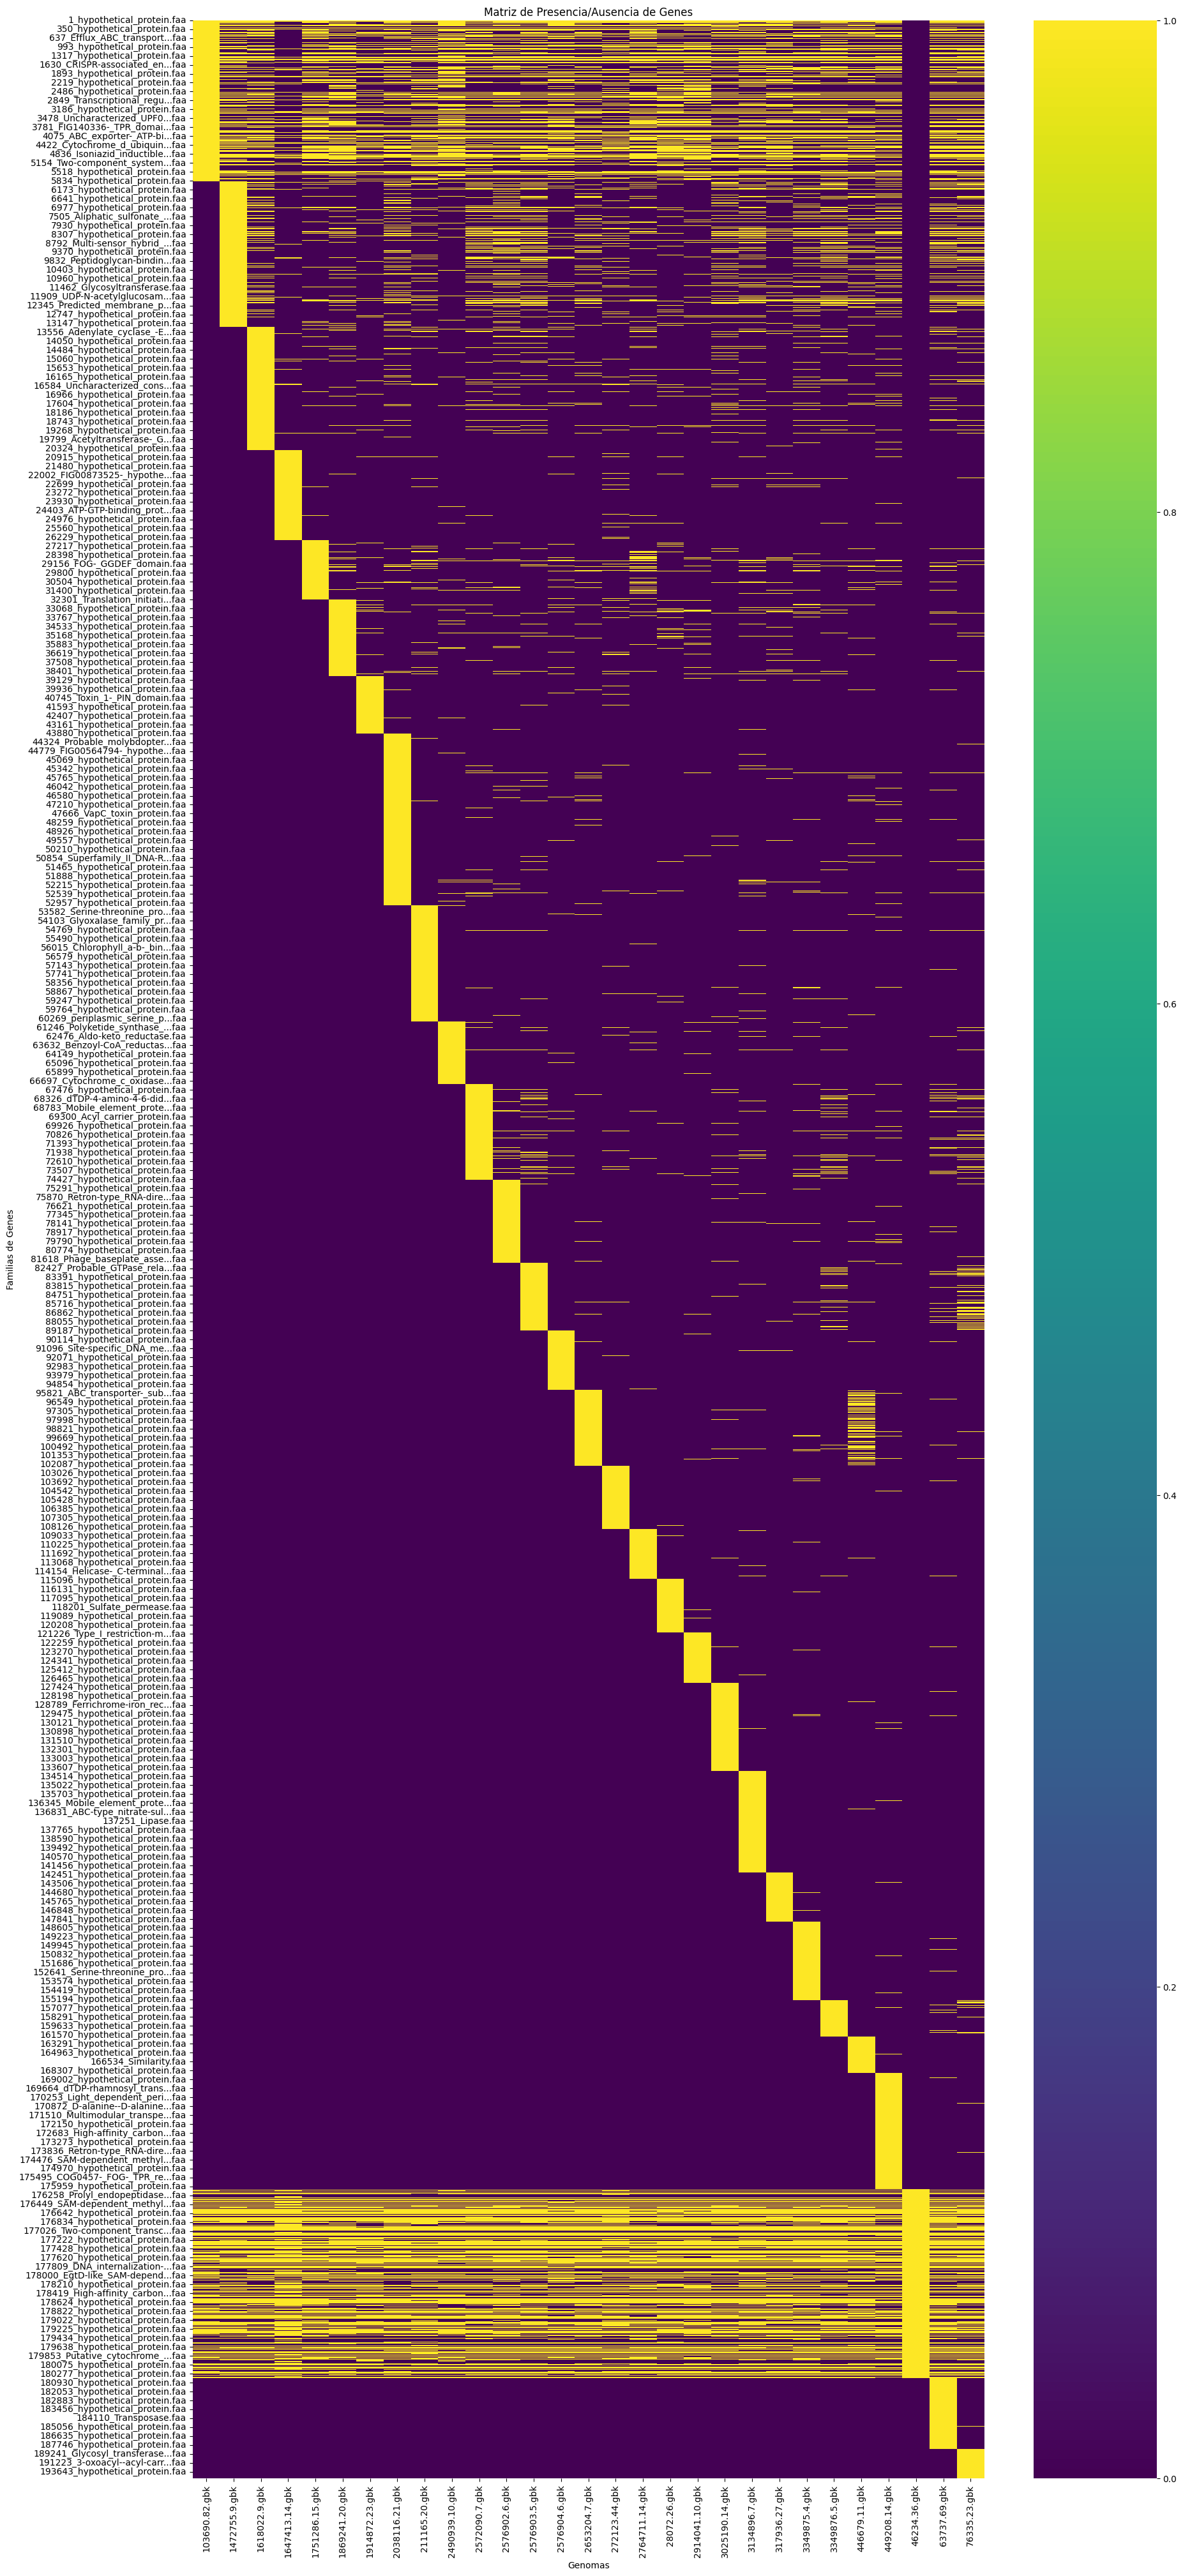

In [8]:
plt.figure(figsize=(20, 50))  # Ajusta el tamaño según la cantidad de datos
sns.heatmap(pangenome_matrix, cmap="viridis", cbar=True)
#Si hay muchas filas (familias de genes), Seaborn intenta ajustar todo en la figura, lo que hace que algunas filas se fusionen visualmente.

plt.title("Matriz de Presencia/Ausencia de Genes")
plt.xlabel("Genomas")
plt.ylabel("Familias de Genes")
plt.xticks(rotation=90)  # Rota etiquetas si hay muchas
plt.show()

In [349]:
plt.figure(figsize=(20, 50))  # Ajusta el tamaño según la cantidad de datos
sns.heatmap(pangenome_matrix, cmap="viridis", cbar=True)

plt.title("Matriz de Presencia/Ausencia de Genes")
plt.xlabel("Genomas")
plt.ylabel("Familias de Genes")
plt.xticks(rotation=90)

# Exporta la figura
plt.tight_layout()  # Evita cortes de etiquetas
plt.savefig("pangenome_heatmap.png", dpi=300)  # Puedes ajustar dpi para mejor calidad
plt.close()


El **core genome** son los genes esenciales comunes a todas las cepas de una especie, mientras que el **accessory genome** incluye genes presentes solo en algunas cepas, que aportan ventajas como la resistencia a antibióticos o adaptaciones a diferentes entornos.

Este concepto ayuda a detectar **genes primarios** al identificar los genes del **core genome**, que son fundamentales para la supervivencia y las funciones básicas de la especie. Estos genes pueden ser clave para entender procesos biológicos fundamentales y sirven como base para comparar cepas o especies. Por otro lado, el **accessory genome** permite explorar la variabilidad genética que podría estar asociada con características específicas de adaptación o patogenicidad.

📊 INTERPRETACIÓN

* Un gen primario es aquel que está en casi todos los genomas (según el umbral).
*  El umbral del 95% significa que si tienes 100 genomas, el gen debe estar en al menos 95 de ellos.
* Puedes cambiar el umbral según tu criterio (por ejemplo, 90% o 100%).
  
Checar este articulo: ``` "The genetic integrity of bacterial species: the core genome and the accessory genome, two different stories"``

## Filtro 1: quedarse con las familias que aparecen únicamente en el 60% de los genomas

In [320]:
pangenome_matrix = pd.read_csv("pangenome_matrix_t0.tr.csv", sep=",")

# Eliminar las columnas innecesarias (manteniendo solo la primera y las columnas de presencia/ausencia)
pangenome_matrix = pangenome_matrix.drop(pangenome_matrix.columns[1:14], axis=1)

# Extraer solo los valores de presencia/ausencia (ignorando la primera columna con los nombres de las familias de genes)
presence_absence = pangenome_matrix.iloc[:, 1:].astype(int)

# Contar en cuántos genomas aparece cada familia de genes
pangenome_matrix["genomas presentes"] = presence_absence.sum(axis=1)

# Definir umbral para genes presentes en al menos el 80% de los genomas
umbral = int(0.60 * 29)  # 80% de 29 genomas = 23.2, redondeado a 23

# Filtrar las familias que cumplen con el umbral
core_familias = pangenome_matrix[pangenome_matrix["genomas presentes"] >= umbral]

# Guardar la matriz original con la nueva columna
pangenome_matrix.to_csv("pangenome_matrix_con_frecuencia.csv", index=False)

# Guardar solo los nombres de las familias (primera columna) en core_genes.csv
core_familias.iloc[:, 0].to_csv("core_familias.csv", index=False, header=False)

# Mostrar resultados
print(f"Número de familias presentes en al menos el 60% de los genomas: {len(core_genes)}")
core_familias.iloc[:, 0]

Número de familias presentes en al menos el 60% de los genomas: 2870


0               1_hypothetical_protein.faa
1               2_hypothetical_protein.faa
3             4_ATP_synthase_gamma_c...faa
4             5_ATP_synthase_alpha_c...faa
5             6_ATP_synthase_delta_c...faa
                       ...                
49198    180381_3-oxoacyl--acyl-carr...faa
49199      180382_Acyl_carrier_protein.faa
49200    180383_Heterodisulfide_redu...faa
49201    180384_Peptide_deformylase_...faa
49202         180385_serine_proteinase.faa
Name: Gene, Length: 3711, dtype: object

# Matriz de abundancia

 1. Con las familias de genes obtenidas de get homologues, se correra el script ```conteos_por_genoma.sh``` localizado en
*/files/atenea/bacterias/Cianobacterias_corregidas/matriz_abundancia* de geomtop el cual cuenta cuantos genes por genoma estan presentes en cada familia.
2. Los resultados del script anterior estan almacenados en la carpeta */files/atenea/bacterias/Cianobacterias_corregidas/matriz_abundancia/conteos* y con ellos se construira la matriz de abundancia con ayuda del script ```matriz.sh``` (localizado tambien en la misma ruta anterior).
3. Porcentaje de presencia de cada familia en los genomas.

In [122]:
# Cargar la matriz de abundancia
matriz_abundancia = pd.read_csv("matriz_abundancia.csv",sep = "\t")
# Asegurar que la primera columna sea el índice (nombres de genes)
matriz_abundancia.set_index(matriz_abundancia.columns[0], inplace=True)

# Convertir valores a números (por si hay algún problema con tipos de datos)
matriz_abundancia = matriz_abundancia.apply(pd.to_numeric, errors="coerce")
# Ver las primeras filas de la matriz
matriz_abundancia.iloc[2940:2955]

,103690.82,1472755.9,1618022.9,1647413.14,1751286.15,1869241.20,1914872.23,2038116.21,211165.20,2490939.10,2572090.7,2576902.6,2576903.5,2576904.6,2653204.7,272123.44,2764711.14,28072.26,2914041.10,3025190.14,3134896.7,317936.27,3349875.4,3349876.5,446679.11,449208.14,46234.36,63737.69,76335.23
Familia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
112512_Transcriptional_regu..,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
112513_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
112514_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
112524_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11252_hypothetical_protein,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112530_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
112531_Cytochrome_P450_-EC_..,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
112544_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
112552_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
#conteo de en cuantas familias esta presente
# Suponiendo que tu dataframe se llama df y la primera columna es el índice de la familia de genes
matriz_abundancia["presencia"] = 29-((matriz_abundancia == 0).sum(axis=1))
matriz_abundancia["presencia %"] = matriz_abundancia["presencia"]/29
matriz_abundancia

,103690.82,1472755.9,1618022.9,1647413.14,1751286.15,1869241.20,1914872.23,2038116.21,211165.20,2490939.10,2572090.7,2576902.6,2576903.5,2576904.6,2653204.7,272123.44,2764711.14,28072.26,2914041.10,3025190.14,3134896.7,317936.27,3349875.4,3349876.5,446679.11,449208.14,46234.36,63737.69,76335.23,presencia,presencia %
Familia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100024_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0.068966
100029_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0.068966
10002_hypothetical_protein,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.034483
100070_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,4,0.137931
100071_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0.068966
99998_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0.068966
99999_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0.068966


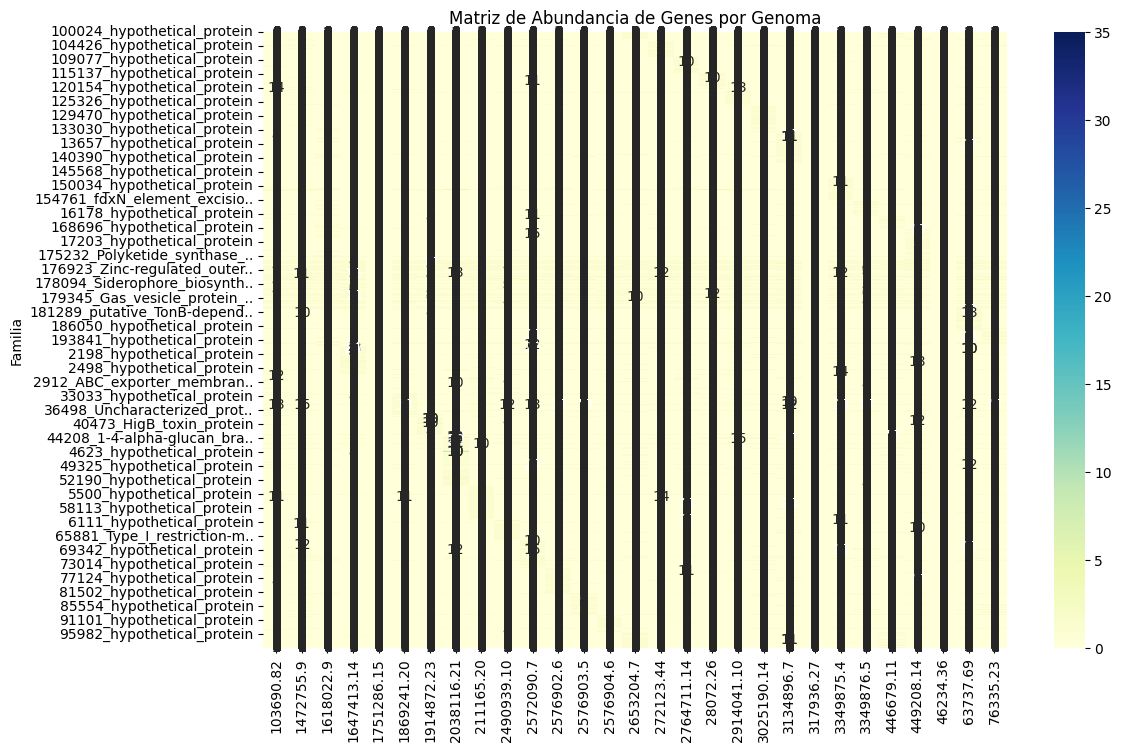

In [15]:
# Usar un mapa de calor para visualizar la abundancia de genes por genoma
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_abundancia.iloc[:, :-2], annot=True, fmt='g', cmap="YlGnBu")
plt.title("Matriz de Abundancia de Genes por Genoma")
plt.show()

## Familias donde hay al menos mas de una copia en algún genoma

In [129]:
# Filtrar filas donde hay al menos un valor mayor a 1 (es decir, hay copias adicionales)
familias_con_copias = matriz_abundancia[(matriz_abundancia.iloc[:,:-2] > 1).any(axis=1)]
# Mostrar las primeras fila
familias_con_copias

,103690.82,1472755.9,1618022.9,1647413.14,1751286.15,1869241.20,1914872.23,2038116.21,211165.20,2490939.10,2572090.7,2576902.6,2576903.5,2576904.6,2653204.7,272123.44,2764711.14,28072.26,2914041.10,3025190.14,3134896.7,317936.27,3349875.4,3349876.5,446679.11,449208.14,46234.36,63737.69,76335.23,presencia,presencia %
Familia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100136_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,1,0,0,0,0,3,0.103448
10039_Methyl-accepting_che..,0,1,2,0,0,0,0,3,2,1,1,1,1,1,3,0,1,1,0,1,2,0,2,2,3,1,0,2,2,20,0.689655
100543_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0.068966
100544_hypothetical_protein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0.068966
10056_hypothetical_protein,0,1,1,0,0,0,0,1,1,2,1,1,1,0,1,0,2,2,1,0,0,0,0,1,1,1,0,1,1,17,0.586207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996_hypothetical_protein,1,1,0,0,0,3,0,0,0,2,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,8,0.275862
9975_High-affinity_carbon..,0,1,1,0,0,0,0,1,0,0,1,2,1,0,1,0,0,0,0,1,2,0,1,1,1,1,0,2,1,15,0.517241
997_hypothetical_protein,1,0,0,1,0,1,1,1,1,1,0,0,0,1,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,12,0.413793


el siguiente array contiene los nombres de las familias con copias y los genomas que contienen copias en estas familias

In [130]:
# Inicializamos el diccionario vacío
familias_con_copias_dict = {}

# Obtenemos las familias
familias = familias_con_copias.index.values

# Iteramos sobre cada familia
for familia in familias:
    # Accedemos a la fila correspondiente a la familia
    genomas_con_copias = familias_con_copias.loc[familia]
    genomas_con_copias = genomas_con_copias.iloc[:-2]
    
    filtered_values = genomas_con_copias[genomas_con_copias > 1].index.values
    filtered_ids_as_float = filtered_values.astype(float).tolist()
    familias_con_copias_dict[familia] = filtered_ids_as_float

### Filtro 2: considerar aquellas familias que esten presentes en el 80% de los genomas y que además existan varios genes de un mismo genoma con presencia en una misma familia

In [131]:
# familias que tienen al menos una copia (2685)
familias_copias = familias_con_copias_dict.keys()
# familias presentes en al menos el 80% de los genomas(2983)
familias_mayoritarias = core_familias.iloc[:,0].tolist()
familias_mayoritarias = [nombre.replace(".faa", "") for nombre in familias_mayoritarias]# quitar extension
# familias que cumplen ambas condiciones(409)
familias_mayoritarias_con_copias = list(set(familias_mayoritarias) & set(familias_copias))

In [132]:
# exportar la interseccion de ambas familias a un csv
familias_interes = pd.DataFrame(familias_mayoritarias_con_copias, columns=["Familias"])
familias_interes.to_csv("familias_mayoritarias_con_copias.csv", index=False)

### mapa de calor para visualizar la abaundancia de genes por genoma en las familias de interés

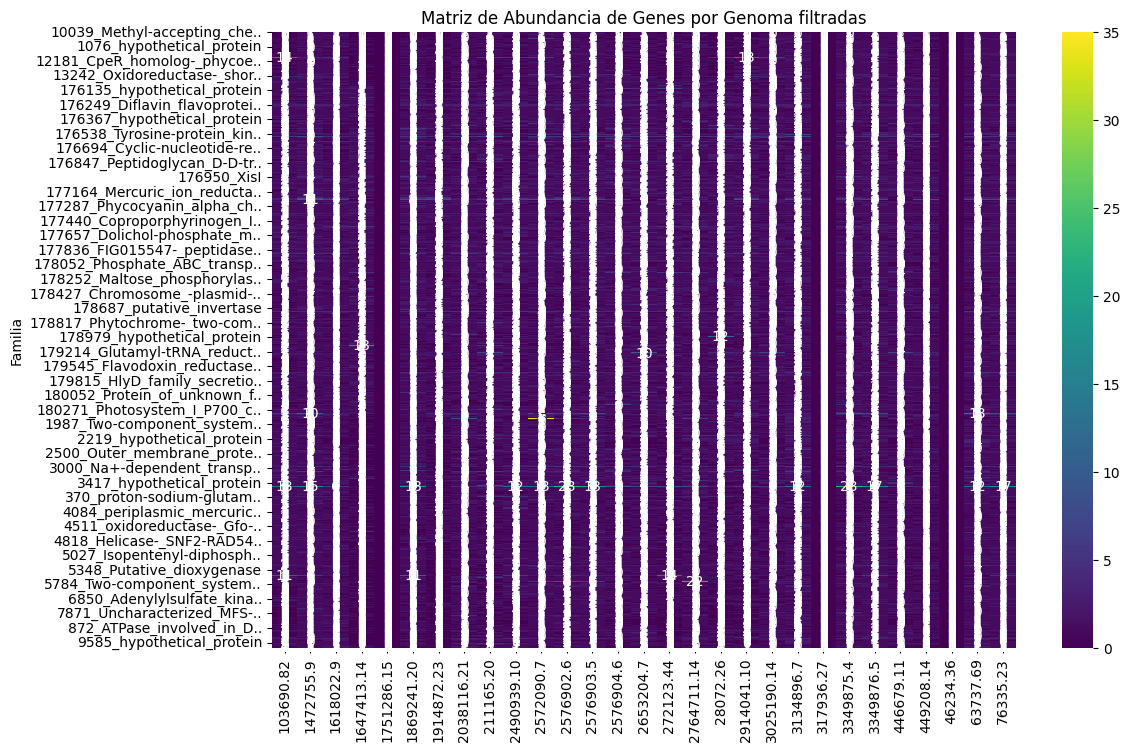

In [133]:
# Usar un mapa de calor para visualizar la abundancia de genes por genoma
# Excluir las dos últimas filas
familias_filtradas = familias_con_copias.loc[familias_con_copias.index.isin(familias_mayoritarias_con_copias)].iloc[:, :-2]

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(familias_filtradas, annot=True, fmt='g', cmap="viridis")
plt.title("Matriz de Abundancia de Genes por Genoma filtradas")
plt.show()

In [134]:
familias_filtradas

,103690.82,1472755.9,1618022.9,1647413.14,1751286.15,1869241.20,1914872.23,2038116.21,211165.20,2490939.10,2572090.7,2576902.6,2576903.5,2576904.6,2653204.7,272123.44,2764711.14,28072.26,2914041.10,3025190.14,3134896.7,317936.27,3349875.4,3349876.5,446679.11,449208.14,46234.36,63737.69,76335.23
Familia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10039_Methyl-accepting_che..,0,1,2,0,0,0,0,3,2,1,1,1,1,1,3,0,1,1,0,1,2,0,2,2,3,1,0,2,2
10056_hypothetical_protein,0,1,1,0,0,0,0,1,1,2,1,1,1,0,1,0,2,2,1,0,0,0,0,1,1,1,0,1,1
10124_WD-40_repeat,0,1,1,0,0,0,0,1,2,1,1,1,2,0,1,0,0,0,0,1,1,0,1,1,1,1,0,1,1
10175_putative_anion_perme..,0,1,1,0,0,1,0,1,1,1,2,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1
10314_LemA_protein,0,1,2,0,0,0,0,1,1,0,1,1,1,0,1,1,2,0,0,1,1,0,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967_Threonine_dehydrogen..,2,1,1,0,0,2,0,3,4,3,1,1,1,0,2,1,2,2,0,1,2,0,1,1,2,2,0,3,1
968_hypothetical_protein,1,1,1,0,0,1,0,1,2,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1
971_hypothetical_protein,1,1,1,1,0,1,1,1,0,1,1,2,1,0,1,1,0,0,1,0,0,0,1,1,1,0,0,1,1


In [135]:
familias_filtradas.to_csv("matriz_abundancia_filtrada.csv",sep ="\t")

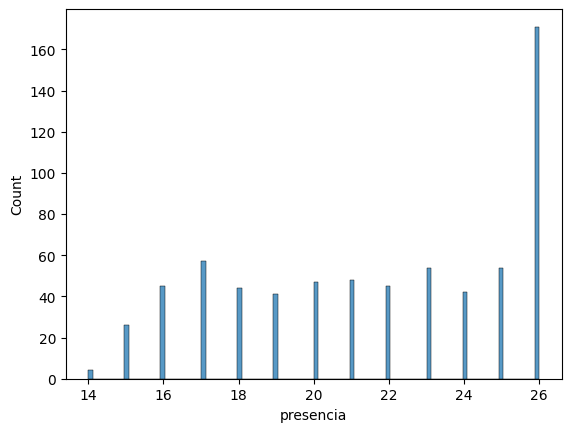

In [136]:
sns.histplot( familias_con_copias.loc[familias_con_copias.index.isin(familias_mayoritarias_con_copias)]['presencia'], bins=100, kde=False) 
plt.show()

### Filtro 3: considerar aquellas familias cuyos archivos en BLAST las secuencias de alineación sean mayores a 500pb

El penúltimo filtro será considerar las familias que al ser sometidas a BLAST las secuencias de comparación tenga longitud de al menos 500.

In [137]:
# Carpeta donde están los archivos CSV
carpeta = 'familias_con_copias/'

# Lista para guardar los nombres de los archivos que cumplen la condición
filtro3 = []

# Itera sobre todos los archivos en la carpeta
for archivo in os.listdir(carpeta):
    # Verifica si el archivo es un archivo CSV
    if archivo.endswith('.csv'):
        # Lee el archivo CSV
        df = pd.read_csv(os.path.join(carpeta, archivo), sep=',')
        
        # Verifica si hay al menos una fila con un valor mayor a 700 en la cuarta columna
        if (df['length'] > 500).any():
            # Agrega el nombre del archivo (sin la extensión) a la lista
            nombre_sin_extension = os.path.splitext(archivo)[0]
            filtro3.append(nombre_sin_extension)

# Imprime la lista de archivos que cumplen la condición
print(len(filtro3))

# Si quieres guardar la lista en un archivo CSV
#pd.DataFrame(archivos_con_condicion, columns=["Archivos"]).to_csv("archivos_con_condicion.csv", index=False)


425


### intersección de los 3 filtros

In [163]:
## interseccion de los 3 filtros
familias_filtradas = list(set(familias_mayoritarias).intersection(filtro3, familias_copias))
print("El numero de familias despues de los 3 filtros es:", len(familias_filtradas))

El numero de familias despues de los 3 filtros es: 205


In [169]:
# copiar archivos de las familias que cumplan los 3 filtros  a la carpeta familias_filtradas
# Carpeta de origen (donde están los archivos)
carpeta_origen = "familias_con_copias/"

# Carpeta de destino (donde quieres copiar los archivos)
carpeta_destino = "familias_filtradas/"

# Asegurar que la carpeta de destino existe
os.makedirs(carpeta_destino, exist_ok=True)

familias_filtradas_csv = [f"{archivo}.csv" for archivo in familias_filtradas]
# Copiar archivos si existen en la carpeta origen
for archivo in familias_filtradas_csv:
    ruta_origen = os.path.join(carpeta_origen, archivo)
    ruta_destino = os.path.join(carpeta_destino, archivo)

    if os.path.exists(ruta_origen):  # Verifica que el archivo existe antes de copiar
        shutil.copy2(ruta_origen, ruta_destino)  # Usa copy2 para mantener metadatos
        print(f"Copiado: {archivo}")
    else:
        print(f"No encontrado: {archivo}")

Copiado: 176673_Cytochrome_c_oxidase...csv
Copiado: 1050_Slr1114_protein.csv
Copiado: 178548_hypothetical_protein.csv
Copiado: 12467_Inner-membrane_proto...csv
Copiado: 176511_Cyclic-nucleotide-re...csv
Copiado: 177481_Lipid_A_export_perme...csv
Copiado: 4818_Helicase-_SNF2-RAD54...csv
Copiado: 178143_Beta-carotene_ketola...csv
Copiado: 178965_Hypothetical_protein...csv
Copiado: 178817_Phytochrome-_two-com...csv
Copiado: 10124_WD-40_repeat.csv
Copiado: 3642_VgrG_protein.csv
Copiado: 2538_Signal_receiver_doma...csv
Copiado: 179315_HlyD_family_secretio...csv
Copiado: 178255_Pyruvate-flavodoxin_...csv
Copiado: 176371_Glycogen_phosphoryla...csv
Copiado: 178887_Hypothetical_protein...csv
Copiado: 5753_hypothetical_protein.csv
Copiado: 176628_Retinal_pigment_epit...csv
Copiado: 11892_Fatty-acid-CoA_ligas...csv
Copiado: 178021_Hypothetical_with_si...csv
Copiado: 177425_FHA_domain_protein.csv
Copiado: 176911_Peptide_chain_releas...csv
Copiado: 176188_Polyphosphate_kinase...csv
Copiado: 179828_

### matrices que almacenan los evalues y los porcentage identity de los genes que contienen posibles candidatos a copias (149)

In [170]:
#fitrar diccionario
# Ruta de la carpeta donde están los archivos
carpeta = "familias_filtradas/"

# Obtener lista de archivos sin extensión
familias = [os.path.splitext(archivo)[0] for archivo in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, archivo))]
# Filtrar el diccionario
familias_interes_dic = {clave: valor for clave, valor in familias_con_copias_dict.items() if clave in familias}

# Imprimir resultado
print(familias_interes_dic)

{'10124_WD-40_repeat': [211165.2, 2576903.5], '1041_hypothetical_protein': [2572090.7, 2576902.6, 2914041.1, 3025190.14, 3134896.7, 449208.14, 63737.69, 76335.23], '1043_hypothetical_protein': [3025190.14, 76335.23], '1048_Hypothetical_protein..': [1869241.2, 2576904.6, 2764711.14, 3134896.7], '1050_Slr1114_protein': [1869241.2, 211165.2, 28072.26, 2914041.1], '1159_Two-component_system..': [2576902.6, 2576903.5, 3349875.4, 3349876.5, 63737.69, 76335.23], '11892_Fatty-acid-CoA_ligas..': [3349875.4], '1198_Ferrichrome-iron_rec..': [103690.82, 1472755.9, 1618022.9, 1869241.2, 1914872.23, 211165.2, 2490939.1, 2572090.7, 2576904.6, 272123.44, 28072.26, 2914041.1, 3025190.14, 3349876.5], '12268_Heterodimeric_efflux..': [2572090.7, 2576903.5, 3349876.5, 76335.23], '12467_Inner-membrane_proto..': [2764711.14], '1286_Two-component_system..': [103690.82, 2490939.1, 2914041.1], '13067_T6SS_baseplate_prote..': [1618022.9], '131_Leucine-rich-repeat_..': [1472755.9, 2572090.7, 2576902.6, 2576903.5,

In [166]:
# nombrar las columnas de las salidad de BLAST
# Directorio donde se encuentran los archivos CSV de BLAST
directorio = "familias_filtradas/"  # Reemplaza con la ruta de tu carpeta

# Nombres de las columnas que deseas agregar
columnas = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
            'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

# Iterar sobre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith(".csv"):
        archivo_path = os.path.join(directorio, archivo)
        
        # Leer el archivo CSV usando el delimitador de tabulador
        df = pd.read_csv(archivo_path, sep=',', header=None)  # Usar sep='\t' para tabuladores
        
        # Asignar los nuevos nombres de las columnas
        df.columns = columnas
        
        # Guardar el archivo con los nuevos nombres de columna, manteniendo el delimitador tabulador
        df.to_csv(archivo_path, index=False, sep=',')
        print(f"Columnas renombradas y archivo guardado: {archivo}")

Columnas renombradas y archivo guardado: 180062_Nitrogenase_-molybde...csv
Columnas renombradas y archivo guardado: 176371_Glycogen_phosphoryla...csv
Columnas renombradas y archivo guardado: 3276_Multimodular_transpe...csv
Columnas renombradas y archivo guardado: 179748_Putative_porin.csv
Columnas renombradas y archivo guardado: 6993_Two-component_system...csv
Columnas renombradas y archivo guardado: 178290_HlyD_family_secretio...csv
Columnas renombradas y archivo guardado: 2164_Two-component_system...csv
Columnas renombradas y archivo guardado: 2956_hypothetical_protein.csv
Columnas renombradas y archivo guardado: 179108_Retron-type_RNA-dire...csv
Columnas renombradas y archivo guardado: 180037_Nitrogenase_-molybde...csv
Columnas renombradas y archivo guardado: 177740_NADH_dehydrogenase_s...csv
Columnas renombradas y archivo guardado: 180271_Photosystem_I_P700_c...csv
Columnas renombradas y archivo guardado: 179828_L-aspartate_oxidase_...csv
Columnas renombradas y archivo guardado: 17

/tmp/ipykernel_3314023/1091172126.py:15: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(archivo_path, sep=',', header=None)  # Usar sep='\t' para tabuladores


Columnas renombradas y archivo guardado: 349_serine-threonine_kin...csv
Columnas renombradas y archivo guardado: 5270_Beta-lactamase_class...csv
Columnas renombradas y archivo guardado: 513_hypothetical_protein.csv
Columnas renombradas y archivo guardado: 12268_Heterodimeric_efflux...csv
Columnas renombradas y archivo guardado: 180207_Membrane_protein_con...csv
Columnas renombradas y archivo guardado: 2244_hypothetical_protein.csv
Columnas renombradas y archivo guardado: 178817_Phytochrome-_two-com...csv
Columnas renombradas y archivo guardado: 178032_Heat_shock_protein_6...csv
Columnas renombradas y archivo guardado: 5348_Putative_dioxygenase.csv
Columnas renombradas y archivo guardado: 176225_Glucose-methanol-cho...csv
Columnas renombradas y archivo guardado: 178062_2-isopropylmalate_sy...csv
Columnas renombradas y archivo guardado: 5567_Putative_hemagglutin...csv
Columnas renombradas y archivo guardado: 4126_Two-component_system...csv
Columnas renombradas y archivo guardado: 1159_Tw

In [173]:
# Itera sobre las familias
familias_con_repeticion = []
for familia in familias_interes_dic.keys():
    # Crea un DataFrame para cada familia
    df_familia = pd.read_csv(f'familias_filtradas/{familia}.csv', sep=',')
    # Detectar duplicados en base a columnas específicas
    duplicados = df_familia[df_familia.duplicated(subset=["qsquid", "ssquid"])]

    if  duplicados.empty:
        # Crear la matriz con qsquid como filas, ssquid como columnas y evalue/pident como valores
        matriz_pident = df_familia.pivot(index="qsquid", columns="ssquid", values="pident")
        matriz_evalue = df_familia.pivot(index="qsquid", columns="ssquid", values="evalue")
        # Guarda las matrices como archivos CSV con el nombre de la familia y el sufijo correspondiente
        matriz_pident.to_csv(f'matrices/{familia}_matriz_pident.csv', index=True)
        matriz_evalue.to_csv(f'matrices/{familia}_matriz_evalue.csv', index=True)
    else:
        familias_con_repeticion.append(familia)

In [174]:
len(familias_con_repeticion)

75

#### carga de matrices ejemplo para la familia:1048_Hypothetical_protein..

In [175]:
# Cargar el archivo en un DataFrame
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evita que se corte la vista en múltiples líneas
df_evalue = pd.read_csv('matrices/12467_Inner-membrane_proto.._matriz_evalue.csv', sep=',')  # Reemplaza 'archivo.tsv' con tu archivo real
df_pident = pd.read_csv('matrices/12467_Inner-membrane_proto.._matriz_pident.csv', sep=',')

df_evalue[0:10]

,qsquid,1472755.9.peg.6613,1618022.9.peg.5504,1751286.16.peg.5440,2038116.21.peg.5352,2572090.7.peg.6068,2576902.6.peg.1952,2576903.5.peg.4776,2576904.6.peg.4471,2653204.7.peg.6197,2764711.14.peg.2199,2764711.14.peg.4831,3025190.14.peg.5763,3134896.7.peg.7836,317936.28.peg.2492,3349875.4.peg.3937,3349876.5.peg.6341,446679.11.peg.2396,449208.14.peg.2153,63737.69.peg.4344,76335.23.peg.3892
0,1472755.9.peg.6613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1618022.9.peg.5504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1751286.16.peg.5440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2038116.21.peg.5352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2572090.7.peg.6068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2576902.6.peg.1952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2576903.5.peg.4776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2576904.6.peg.4471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2653204.7.peg.6197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2764711.14.peg.2199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df_evalue

,qseqid,103690.82.peg.1048,1472755.9.peg.3042,1618022.9.peg.2442,1751286.16.peg.2200,1751286.16.peg.2634,1869241.20.peg.3707,1869241.20.peg.6320,1914872.23.peg.2858,2038116.21.peg.549,211165.20.peg.2872,2490939.10.peg.2229,2572090.7.peg.3899,2576902.6.peg.5013,2576903.5.peg.2254,2576904.6.peg.2781,2576904.6.peg.4402,2653204.7.peg.355,272123.44.peg.1555,2764711.14.peg.359,2764711.14.peg.5678,28072.26.peg.4792,2914041.10.peg.5950,3025190.14.peg.2900,3134896.7.peg.3276,3134896.7.peg.5866,317936.28.peg.85,3349875.4.peg.3005,3349876.5.peg.3140,446679.11.peg.1579,63737.69.peg.1175,76335.23.peg.289
0,103690.82.peg.1048,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.960000e-145,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.630000e-156,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1472755.9.peg.3042,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.980000e-152,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.650000e-155,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1618022.9.peg.2442,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.720000e-147,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.570000e-153,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1751286.16.peg.2200,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e-125,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.110000e-130,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,1751286.16.peg.2634,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.150000e-143,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.150000e-148,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,1869241.20.peg.3707,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.710000e-122,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.310000e-124,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,1869241.20.peg.6320,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.250000e-142,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.410000e-147,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,1914872.23.peg.2858,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.660000e-148,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.120000e-151,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0

In [176]:
df_pident

,qsquid,1472755.9.peg.6613,1618022.9.peg.5504,1751286.16.peg.5440,2038116.21.peg.5352,2572090.7.peg.6068,2576902.6.peg.1952,2576903.5.peg.4776,2576904.6.peg.4471,2653204.7.peg.6197,2764711.14.peg.2199,2764711.14.peg.4831,3025190.14.peg.5763,3134896.7.peg.7836,317936.28.peg.2492,3349875.4.peg.3937,3349876.5.peg.6341,446679.11.peg.2396,449208.14.peg.2153,63737.69.peg.4344,76335.23.peg.3892
0,1472755.9.peg.6613,100.000,92.655,84.369,95.247,96.958,93.916,95.817,84.601,95.247,84.369,62.669,91.902,85.499,86.692,94.915,95.817,95.057,95.437,95.817,96.008
1,1618022.9.peg.5504,92.655,100.000,84.181,92.844,93.220,91.525,92.467,83.051,93.974,84.746,61.942,95.669,86.441,87.621,92.655,92.844,93.785,92.655,93.409,92.279
2,1751286.16.peg.5440,84.369,84.181,100.000,85.311,84.746,84.557,85.311,88.324,85.311,95.104,62.136,84.369,86.441,87.259,85.499,85.311,85.311,85.311,84.746,85.122
3,2038116.21.peg.5352,95.247,92.844,85.311,100.000,95.817,93.346,95.627,85.932,96.768,85.687,62.089,92.844,85.876,86.502,93.785,95.247,96.198,97.338,95.627,95.057
4,2572090.7.peg.6068,96.958,93.220,84.746,95.817,100.000,93.916,97.529,85.551,96.578,85.122,62.863,92.655,86.252,87.452,94.350,97.338,96.388,96.768,97.529,97.338
5,2576902.6.peg.1952,93.916,91.525,84.557,93.346,93.916,100.000,93.726,85.361,93.536,84.181,61.896,91.525,86.252,85.932,92.279,93.726,93.346,93.536,93.726,93.536
6,2576903.5.peg.4776,95.817,92.467,85.311,95.627,97.529,93.726,100.000,86.122,96.768,84.934,62.476,92.467,86.252,86.692,94.162,99.430,96.578,96.768,98.479,99.430
7,2576904.6.peg.4471,84.601,83.051,88.324,85.932,85.551,85.361,86.122,100.000,86.122,88.324,60.837,83.051,85.311,87.619,86.064,85.741,86.312,85.932,85.932,85.551
8,2653204.7.peg.6197,95.247,93.974,85.311,96.768,96.578,93.536,96.768,86.122,100.000,85.876,63.250,94.162,87.194,87.452,93.409,96.768,99.430,97.529,97.148,96.578
9,2764711.14.peg.2199,84.369,84.746,95.104,85.687,85.122,84.181,84.934,88.324,85.876,100.000,62.524,84.557,87.759,87.838,85.311,85.311,85.687,86.252,85.499,84.746


### contar cuantos archivos hay en una carpeta

In [151]:
## contar cuantos archivos hay en cada carpeta
from pathlib import Path
# Define la ruta de la carpeta
ruta_carpeta = Path('familias_filtradas/')

# Cuenta cuántos archivos hay en la carpeta
archivos = [f for f in ruta_carpeta.iterdir() if f.is_file()]

# Muestra el número de archivos
print(f'Número de archivos: {len(archivos)}')

Número de archivos: 205


### borrar una carpeta no vacia

In [220]:
#borrar una carpeta
import shutil
# Define la ruta de la carpeta
ruta_carpeta = 'K-means_results/'

# Borra la carpeta y todo su contenido (archivos y subcarpetas)
shutil.rmtree(ruta_carpeta)

### Automatizar los 3 filtros anteriores

In [115]:
## filtro 1
pangenome_matrix = pd.read_csv("pangenome_matrix_t0.tr.csv", sep=",")
# Eliminar las columnas innecesarias (manteniendo solo la primera y las columnas de presencia/ausencia)
pangenome_matrix = pangenome_matrix.drop(pangenome_matrix.columns[1:14], axis=1)
# Extraer solo los valores de presencia/ausencia (ignorando la primera columna con los nombres de las familias de genes)
presence_absence = pangenome_matrix.iloc[:, 1:].astype(int)
# Contar en cuántos genomas aparece cada familia de genes
pangenome_matrix["genomas presentes"] = presence_absence.sum(axis=1)
# Definir umbral para genes presentes en al menos el N% de los genomas
umbral = int(0.60 * 29)  # 80% de 29 genomas = 23.2, redondeado a 23
# Filtrar las familias que cumplen con el umbral
core_familias = pangenome_matrix[pangenome_matrix["genomas presentes"] >= umbral]


# Mostrar resultados
print(f"Número de familias presentes en al menos el 80% de los genomas: {len(core_familias)}")

## filtro 2 ya esta considerado por defecto

# familias que tienen al menos una copia 
familias_copias = familias_con_copias_dict.keys()
# familias presentes en al menos el N% de los genomas
familias_mayoritarias = core_familias.iloc[:,0].tolist()
familias_mayoritarias = [nombre.replace(".faa", "") for nombre in familias_mayoritarias]# quitar extension
# familias que cumplen ambas condiciones
familias_mayoritarias_con_copias = list(set(familias_mayoritarias) & set(familias_copias))
print('Longitud despues de filtro 1 y 2:',len(familias_mayoritarias_con_copias))
## filtro 3
# Carpeta donde están los archivos CSV
carpeta = 'familias_con_copias/'

# Lista para guardar los nombres de los archivos que cumplen la condición
filtro3 = []
# Itera sobre todos los archivos en la carpeta
for archivo in os.listdir(carpeta):
    # Verifica si el archivo es un archivo CSV
    if archivo.endswith('.csv'):
        # Lee el archivo CSV
        df = pd.read_csv(os.path.join(carpeta, archivo), sep=',')
        
        # Verifica si hay al menos una fila con un valor mayor a 700 en la cuarta columna
        if (df['length'] > 500).any():
            # Agrega el nombre del archivo (sin la extensión) a la lista
            nombre_sin_extension = os.path.splitext(archivo)[0]
            filtro3.append(nombre_sin_extension)

# Imprime la lista de archivos que cumplen la condición
#print(len(filtro3))

## interseccion de los 3 filtros
familias_filtradas = list(set(familias_mayoritarias).intersection(filtro3, familias_copias))
print("El numero de familias despues de los 3 filtros es:", len(familias_filtradas))
# Si quieres guardar la lista en un archivo CSV
#pd.DataFrame(archivos_con_condicion, columns=["Archivos"]).to_csv("archivos_con_condicion.csv", index=False)


Número de familias presentes en al menos el 80% de los genomas: 3711
Longitud despues de filtro 1 y 2: 678
El numero de familias despues de los 3 filtros es: 205


## Lo que sigue es para tratar de clasificar los genes en primarios y secundarios

## df que guardan las medias de los evalues y los pident

In [194]:
ruta_salida = "secundarios/"
# Asegurar que la carpeta de destino existe
os.makedirs(ruta_salida, exist_ok=True)
# Iterar sobre cada familia en el diccionario
for familia, genomas_array in familias_interes_dic.items():
    if familia not in familias_con_repeticion:
        # Crear listas para almacenar resultados
        genomas, medias_evalue, medias_pident = [], [], []
        #Leer matrices de pident y evalue
        ruta_pident = f'matrices/{familia}_matriz_pident.csv'
        ruta_evalue = f'matrices/{familia}_matriz_evalue.csv'
        matriz = pd.read_csv(ruta_evalue,sep = ',',index_col=0)
        matriz_pident = pd.read_csv(ruta_pident,sep = ',',index_col=0)
    
        # Iterar sobre cada genoma en la familia
        for genoma in genomas_array:
            # Filtrar filas en ambas matrices
            filas_filtradas = matriz[matriz.index.str.startswith(str(genoma))]
            filas_pident_filtradas = matriz_pident[matriz_pident.index.str.startswith(str(genoma))]
        
            # Almacenar valores de los genes candidatos
            genomas.extend(filas_filtradas.index.values)
            # Calcular medias para cada fila y almacenarlas
            medias_evalue.extend(filas_filtradas.mean(axis=1).values)
            medias_pident.extend(filas_pident_filtradas.mean(axis=1).values)
    
        # Crear DataFrame
        data = {
            'Genoma': genomas,
            'mean evalue': medias_evalue,
            'mean pident': medias_pident
        }
        df_familia = pd.DataFrame(data)
    
      
        nombre_archivo = f"{ruta_salida}{familia}.csv"  # Construye la ruta completa
        df_familia.to_csv(nombre_archivo, index=False)  # Guarda el archivo
        print(f"Archivo guardado: {nombre_archivo}")

Archivo guardado: secundarios/1043_hypothetical_protein.csv
Archivo guardado: secundarios/1048_Hypothetical_protein...csv
Archivo guardado: secundarios/1050_Slr1114_protein.csv
Archivo guardado: secundarios/11892_Fatty-acid-CoA_ligas...csv
Archivo guardado: secundarios/12268_Heterodimeric_efflux...csv
Archivo guardado: secundarios/12467_Inner-membrane_proto...csv
Archivo guardado: secundarios/1286_Two-component_system...csv
Archivo guardado: secundarios/13067_T6SS_baseplate_prote...csv
Archivo guardado: secundarios/145_Photosystem_II_CP47_...csv
Archivo guardado: secundarios/1512_Adenylate_cyclase_-E...csv
Archivo guardado: secundarios/1708_Two-component_system...csv
Archivo guardado: secundarios/176160_Efflux_ABC_transport...csv
Archivo guardado: secundarios/176184_Serine-threonine_kin...csv
Archivo guardado: secundarios/176188_Polyphosphate_kinase...csv
Archivo guardado: secundarios/176249_Diflavin_flavoprotei...csv
Archivo guardado: secundarios/176252_NAD-P-H-quinone_oxid...csv
Arch

In [179]:
len(familias_con_repeticion)

75

In [185]:
def clasificar_genomas(input_file, output_folder):
    # Cargar datos
    df = pd.read_csv(input_file, sep=',')
    df['ID_Genoma'] = df['Genoma'].str.extract(r'(^[\d.]+)')[0].str.rstrip('.')
    
    # Reordenar las columnas
    df = df[['ID_Genoma', 'Genoma', 'mean evalue', 'mean pident']]
    
    # Cambiar los nombres de las columnas
    df.columns = ['ID_Genoma', 'gen', 'mean evalue', 'mean pident']
    
    # Ordenar por Genoma, e-value (ascendente, mejor primero) y pident (descendente, mejor primero)
    df.sort_values(by=["ID_Genoma", "mean evalue", "mean pident"], ascending=[True, True, False], inplace=True)
    
    etiquetas = []  # Lista para almacenar las etiquetas
    
    # Definir un margen de tolerancia (puedes ajustar estos valores)
    epsilon_evalue = 1e-10  # Tolerancia en mean evalue
    epsilon_pident = 0.5    # Tolerancia en mean pident (en porcentaje)
    
    for genoma, grupo in df.groupby("ID_Genoma"):
        grupo = grupo.copy()

        # Si hay un solo gen en el genoma, es primario por defecto
        if len(grupo) == 1:
            grupo["Clasificacion"] = "primario"
            etiquetas.extend(grupo["Clasificacion"])
            continue

        # Inicializar etiquetas como "secundario"
        grupo["Clasificacion"] = "secundario"

        # Valores de referencia
        mejor_fila = grupo.iloc[0]
        mejor_evalue = mejor_fila["mean evalue"]
        mejor_pident = mejor_fila["mean pident"]

        # Criterios más estrictos
        umbral_evalue = mejor_evalue * 10**(-1)  # Un orden de magnitud menor
        pident_corte = grupo["mean pident"].quantile(0.90)  # Solo el 10% superior en pident
        #pident_corte = 90
        # Aplicar criterios para identificar "primarios"
        primarios = (grupo["mean evalue"] <= umbral_evalue) & (grupo["mean pident"] >= pident_corte)

        # Si no hay primarios, forzar al mejor gen como primario
        if primarios.sum() == 0:
            grupo.at[grupo.index[0], "Clasificacion"] = "primario"
        else:
            grupo.loc[primarios, "Clasificacion"] = "primario"
        
        # Comparar genes dentro de un margen de tolerancia
        for i, row in grupo.iterrows():
            for j, row2 in grupo.iterrows():
                if i != j:
                    # Si las métricas son suficientemente cercanas, clasificamos como primarios
                    evalue_diff = abs(row['mean evalue'] - row2['mean evalue'])
                    pident_diff = abs(row['mean pident'] - row2['mean pident'])

                    if evalue_diff <= epsilon_evalue and pident_diff <= epsilon_pident:
                        grupo.at[i, "Clasificacion"] = "primario"
                        grupo.at[j, "Clasificacion"] = "primario"

        # Agregar las etiquetas al final
        etiquetas.extend(grupo["Clasificacion"])
    
    # Asignar las etiquetas al DataFrame original
    df["Etiqueta"] = etiquetas

    # Crear la carpeta de salida si no existe
    os.makedirs(output_folder, exist_ok=True)
    
    # Guardar resultado en la carpeta de salida
    output_file = os.path.join(output_folder, os.path.basename(input_file))
    df.to_csv(output_file, index=False)

# Carpeta de entrada y salida
input_folder = "secundarios/"  # Ajusta la carpeta de entrada
output_folder = "clasificacion/"  # Ajusta la carpeta de salida
# Asegurar que la carpeta de destino existe
os.makedirs(ruta_salida, exist_ok=True)
# Iterar sobre los archivos en la carpeta de entrada
for file in os.listdir(input_folder):
    if file.endswith(".txt") or file.endswith(".csv"):  # Ajusta las extensiones si es necesario
        file_path = os.path.join(input_folder, file)
        clasificar_genomas(file_path, output_folder)


### Algortimos de clusterización:

### K-means

#### Ejemplo para un archivo

Algunos ejemplos de como esta clusterizando el algoritmo:

1. Para esta familia hay mas genes primarios que secundarios (en la mayoría sucede esto): ``` 176249_Diflavin_flavoprotei...csv``` tambien en esta ```176673_Cytochrome_c_oxidase...csv```.
2. Ejemplo de archivos más balanceado: ```176371_Glycogen_phosphoryla...csv```, ```176923_Zinc-regulated_outer...csv```.
3. Ejemplo de archivo con sólo dos genes:```176676_4Fe-4S_ferredoxin_do...csv ```.

In [253]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Cargar el archivo CSV de entrada
input_file = 'secundarios/176923_Zinc-regulated_outer...csv'  # Cambia el nombre del archivo según corresponda
output_dir = "K-means_results"
os.makedirs(output_dir, exist_ok=True)

# Cargar los datos desde el archivo CSV
df = pd.read_csv(input_file)

df['ID_Genoma'] = df['Genoma'].str.extract(r'(^[\d.]+)')[0].str.rstrip('.')
    
# Reordenar las columnas
df = df[['ID_Genoma', 'Genoma', 'mean evalue', 'mean pident']]
    
# Cambiar los nombres de las columnas
df.columns = ['ID_Genoma', 'gen', 'mean evalue', 'mean pident']

# Ordenar por ID_Genoma, e-value (ascendente, mejor primero) y pident (descendente, mejor primero)
df.sort_values(by=["ID_Genoma", "mean evalue", "mean pident"], ascending=[True, True, False], inplace=True)

# Seleccionar características para clustering
X = df[['mean evalue', 'mean pident']]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means (n_clusters=2 para "primario" y "secundario")
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Determinar la etiqueta del primer gen
primer_cluster = df.iloc[0]['cluster']  # Obtener el cluster de la primera fila

# Asignar etiquetas dinámicamente
df['etiqueta'] = df['cluster'].map({primer_cluster: 'primario', 1 - primer_cluster: 'secundario'})

# Guardar el DataFrame resultante en un archivo CSV de salida
output_file = os.path.join(output_dir, '176')  # Ruta completa para guardar el archivo
df.to_csv(output_file, index=False)

# Mostrar los resultados por consola con las columnas correctas
print(df[['ID_Genoma', 'gen', 'mean evalue', 'mean pident', 'cluster', 'etiqueta']])


     ID_Genoma                  gen    mean evalue  mean pident  cluster    etiqueta
2    2572090.7   2572090.7.peg.7392   0.000000e+00    67.457825        0    primario
0    2572090.7   2572090.7.peg.1283  6.050000e-176    63.362075        0    primario
1    2572090.7   2572090.7.peg.2707  8.225000e-165    58.646950        1  secundario
4    2576902.6   2576902.6.peg.3293   0.000000e+00    67.065575        0    primario
5    2576902.6   2576902.6.peg.4571  4.100000e-176    63.749650        0    primario
3    2576902.6   2576902.6.peg.1155  6.975000e-165    59.058975        1  secundario
8    2576903.5   2576903.5.peg.5891   0.000000e+00    67.044475        0    primario
7    2576903.5   2576903.5.peg.3029  1.697500e-174    64.104225        0    primario
6    2576903.5   2576903.5.peg.1429  3.500000e-166    58.700650        1  secundario
10  2764711.14  2764711.14.peg.6514  2.550236e-170    56.544250        1  secundario
9   2764711.14  2764711.14.peg.3683  7.675000e-164    68.183600  

In [210]:
df1 = pd.read_csv('clasificacion/1512_Adenylate_cyclase_-E...csv')
df1

,ID_Genoma,gen,mean evalue,mean pident,Etiqueta
0,103690.82,103690.82.peg.3495,0.000000e+00,62.584273,primario
1,103690.82,103690.82.peg.1512,0.000000e+00,53.098341,secundario
2,1472755.90,1472755.9.peg.585,0.000000e+00,65.458795,primario
3,1472755.90,1472755.9.peg.1182,0.000000e+00,53.581932,secundario
4,1618022.90,1618022.9.peg.3056,2.954545e-182,64.843205,primario
5,1618022.90,1618022.9.peg.3531,6.159091e-176,48.608386,secundario
6,1869241.20,1869241.20.peg.1889,0.000000e+00,62.311477,primario
7,1869241.20,1869241.20.peg.803,0.000000e+00,53.334568,secundario
8,2038116.21,2038116.21.peg.6197,0.000000e+00,64.996977,primario
9,2038116.21,2038116.21.peg.8261,0.000000e+00,49.207636,secundario


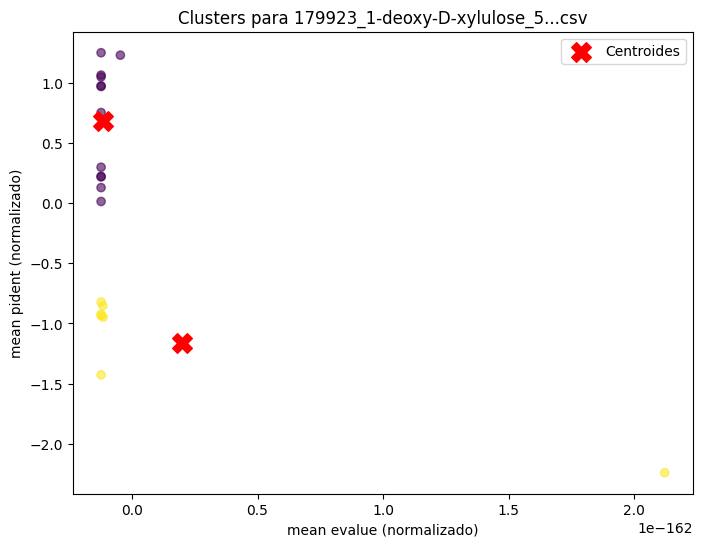

In [254]:
# Visualización de clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.xlabel('mean evalue (normalizado)')
plt.ylabel('mean pident (normalizado)')
plt.title(f'Clusters para {file}')
plt.legend()
plt.show()


### automatizar lo anterior para todos mis archivos

In [222]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Directorios de entrada y salida
input_dir = 'secundarios'  # Carpeta con archivos CSV
output_dir = 'K-means_results'
os.makedirs(output_dir, exist_ok=True)

# Obtener lista de archivos CSV en la carpeta de entrada
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

for file in csv_files:
    input_file = os.path.join(input_dir, file)
    output_file = os.path.join(output_dir, file)  # Mantener el mismo nombre de archivo
    
    # Cargar los datos desde el archivo CSV
    df = pd.read_csv(input_file)
    
    # Extraer ID_Genoma y organizar columnas
    df['ID_Genoma'] = df['Genoma'].str.extract(r'(^[\d.]+)')[0].str.rstrip('.')
    df = df[['ID_Genoma', 'Genoma', 'mean evalue', 'mean pident']]
    df.columns = ['ID_Genoma', 'gen', 'mean evalue', 'mean pident']
    
    # Ordenar por ID_Genoma, mean evalue y mean pident
    df.sort_values(by=['ID_Genoma', 'mean evalue', 'mean pident'], ascending=[True, True, False], inplace=True)
    
    # Seleccionar características y normalizar
    X = df[['mean evalue', 'mean pident']]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Determinar la etiqueta del primer gen
    primer_cluster = df.iloc[0]['cluster']
    df['etiqueta'] = df['cluster'].map({primer_cluster: 'primario', 1 - primer_cluster: 'secundario'})
    
    # Guardar el resultado en la carpeta de salida
    df.to_csv(output_file, index=False)
    print(f'Procesado: {file} -> Guardado en {output_file}')


Procesado: 180062_Nitrogenase_-molybde...csv -> Guardado en K-means_results/180062_Nitrogenase_-molybde...csv
Procesado: 176371_Glycogen_phosphoryla...csv -> Guardado en K-means_results/176371_Glycogen_phosphoryla...csv
Procesado: 3276_Multimodular_transpe...csv -> Guardado en K-means_results/3276_Multimodular_transpe...csv
Procesado: 179748_Putative_porin.csv -> Guardado en K-means_results/179748_Putative_porin.csv
Procesado: 178290_HlyD_family_secretio...csv -> Guardado en K-means_results/178290_HlyD_family_secretio...csv
Procesado: 2956_hypothetical_protein.csv -> Guardado en K-means_results/2956_hypothetical_protein.csv
Procesado: 179108_Retron-type_RNA-dire...csv -> Guardado en K-means_results/179108_Retron-type_RNA-dire...csv
Procesado: 180037_Nitrogenase_-molybde...csv -> Guardado en K-means_results/180037_Nitrogenase_-molybde...csv
Procesado: 177740_NADH_dehydrogenase_s...csv -> Guardado en K-means_results/177740_NADH_dehydrogenase_s...csv
Procesado: 180271_Photosystem_I_P700_c

### conteo de genes primarios y secundarios

#### conteo con Kmeans

In [298]:
# Directorios de entrada y salida
input_dir = "K-means_results/"

# Lista para almacenar los resultados por genoma
conteo_genes = {}

# Procesar cada archivo CSV en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)
        
        # Contar genes secundarios por genoma
        secundarios_por_genoma = df[df['etiqueta'] == 'secundario'].groupby('ID_Genoma').size()
        
        # Acumular los conteos
        for genoma, count in secundarios_por_genoma.items():
            conteo_genes[genoma] = conteo_genes.get(genoma, 0) + count

# Crear DataFrame con los resultados
conteo_secundarios_K_means = pd.DataFrame(list(conteo_genes.items()), columns=['Genoma', 'Número de genes copia'])

# Calcular el total de genes secundarios
total_secundarios = conteo_secundarios_K_means['Número de genes copia'].sum()

# Agregar fila del total
conteo_secundarios_K_means.loc[len(conteo_secundarios_K_means)] = ['Total', total_secundarios]

# Mostrar el DataFrame resultante
conteo_secundarios_K_means

,Genoma,Número de genes copia
0,2490939.1,38
1,103690.82,30
2,211165.2,60
3,1472755.9,31
4,2576904.6,32
5,2764711.14,44
6,3134896.7,52
7,3349875.4,33
8,63737.69,40
9,272123.44,28


In [310]:
import os
import pandas as pd

# Directorios de entrada
input_dir = "K-means_results/"

# Diccionario para almacenar los resultados por genoma
conteo_genes = {}

# Procesar cada archivo CSV en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)

        # Filtrar genes secundarios y contar IDs únicos por genoma
        secundarios_por_genoma = df[df['etiqueta'] == 'secundario'].groupby('ID_Genoma')['gen'].nunique()

        # Acumular los conteos
        for genoma, count in secundarios_por_genoma.items():
            conteo_genes[genoma] = conteo_genes.get(genoma, 0) + count

# Crear DataFrame con los resultados
conteo_secundarios_K_means = pd.DataFrame(list(conteo_genes.items()), columns=['Genoma', 'Número de genes copia únicos'])

# Calcular el total de genes secundarios
total_secundarios = conteo_secundarios_K_means['Número de genes copia únicos'].sum()

# Agregar fila del total
conteo_secundarios_K_means.loc[len(conteo_secundarios_K_means)] = ['Total', total_secundarios]

# Mostrar el DataFrame resultante
conteo_secundarios_K_means


,Genoma,Número de genes copia únicos
0,2490939.1,38
1,103690.82,30
2,211165.2,60
3,1472755.9,31
4,2576904.6,32
5,2764711.14,44
6,3134896.7,52
7,3349875.4,33
8,63737.69,40
9,272123.44,28


In [268]:
# Directorios de entrada y salida
input_dir = "K-means_results/"

# Lista para almacenar los resultados por genoma
conteo_genes = {}

# Procesar cada archivo CSV en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)
        
        # Contar genes secundarios por genoma
        primarios_por_genoma = df[df['etiqueta'] == 'primario'].groupby('ID_Genoma').size()
        
        # Acumular los conteos
        for genoma, count in primarios_por_genoma.items():
            conteo_genes[genoma] = conteo_genes.get(genoma, 0) + count

# Crear DataFrame con los resultados
conteo_primarios_K_means = pd.DataFrame(list(conteo_genes.items()), columns=['Genoma', 'Número de genes primarios'])

# Calcular el total de genes secundarios
total_primarios = conteo_primarios_K_means['Número de genes primarios'].sum()

# Agregar fila del total
conteo_primarios_K_means.loc[len(conteo_primarios_K_means)] = ['Total', total_primarios]

# Mostrar el DataFrame resultante
conteo_primarios_K_means

,Genoma,Número de genes primarios
0,2490939.1,75
1,103690.82,68
2,211165.2,76
3,1472755.9,72
4,2576904.6,62
5,2764711.14,72
6,3134896.7,81
7,3349875.4,70
8,63737.69,75
9,76335.23,77


#### conteo con clasificación por umbrales

In [329]:
# Directorios de entrada y salida
input_dir = "clasificacion/"

# Lista para almacenar los resultados por genoma
conteo_genes = {}

# Procesar cada archivo CSV en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)
        
        # Contar genes secundarios por genoma
        secundarios_por_genoma = df[df['Etiqueta'] == 'secundario'].groupby('ID_Genoma').size()
        
        # Acumular los conteos
        for genoma, count in secundarios_por_genoma.items():
            conteo_genes[genoma] = conteo_genes.get(genoma, 0) + count

# Crear DataFrame con los resultados
conteo_secundarios_umbrales = pd.DataFrame(list(conteo_genes.items()), columns=['Genoma', 'Número de genes copia'])

# Calcular el total de genes secundarios
total_secundarios = conteo_secundarios_umbrales['Número de genes copia'].sum()

# Agregar fila del total
conteo_secundarios_umbrales.loc[len(conteo_secundarios_umbrales)] = ['Total', total_secundarios]

# Mostrar el DataFrame resultante
conteo_secundarios_umbrales

,Genoma,Número de genes copia
0,2490939.1,58
1,103690.82,48
2,211165.2,72
3,1472755.9,50
4,2576904.6,45
5,2764711.14,60
6,3134896.7,65
7,3349875.4,51
8,63737.69,56
9,76335.23,53


In [331]:
media_secundarios_umbrales = conteo_secundarios_umbrales['Número de genes copia'].iloc[:-1].mean()

print('La media de genes secundarios por genoma es:', media_secundarios_umbrales)

La media de genes secundarios por genoma es: 47.38461538461539


In [333]:
# Directorios de entrada y salida
input_dir = "clasificacion/"

# Lista para almacenar los resultados por genoma
conteo_genes = {}

# Procesar cada archivo CSV en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)
        
        # Contar genes secundarios por genoma
        primarios_por_genoma = df[df['Etiqueta'] == 'primario'].groupby('ID_Genoma').size()
        
        # Acumular los conteos
        for genoma, count in primarios_por_genoma.items():
            conteo_genes[genoma] = conteo_genes.get(genoma, 0) + count

# Crear DataFrame con los resultados
conteo_primarios_umbrales = pd.DataFrame(list(conteo_genes.items()), columns=['Genoma', 'Número de genes primarios'])

# Calcular el total de genes secundarios
total_primarios = conteo_primarios_umbrales['Número de genes primarios'].sum()

# Agregar fila del total
conteo_primarios_umbrales.loc[len(conteo_primarios_umbrales)] = ['Total', total_primarios]

# Mostrar el DataFrame resultante
conteo_primarios_umbrales

,Genoma,Número de genes primarios
0,2490939.1,55
1,103690.82,48
2,211165.2,64
3,1472755.9,51
4,2576904.6,47
5,2764711.14,54
6,3134896.7,68
7,3349875.4,52
8,63737.69,59
9,76335.23,56


In [335]:
media_primarios_umbrales = conteo_primarios_umbrales['Número de genes primarios'].iloc[:-1].mean()

print('La media de genes primarios por genoma es:', media_primarios_umbrales)

La media de genes primarios por genoma es: 49.80769230769231


###  diccionarios que almacenan los genes copia de los genomas

### umbrales

In [303]:
# Directorio de entrada
input_dir = "clasificacion/"

# Diccionario para almacenar los genes secundarios por genoma
genes_secundarios_por_genoma = {}

# Procesar cada archivo CSV en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)
        
        # Filtrar genes secundarios
        secundarios = df[df['Etiqueta'] == 'secundario'][['ID_Genoma', 'gen']]
        
        # Agrupar por genoma y agregar los IDs de genes secundarios
        for genoma, grupo in secundarios.groupby('ID_Genoma'):
            if genoma not in genes_secundarios_por_genoma:
                genes_secundarios_por_genoma[genoma] = set()
            genes_secundarios_por_genoma[genoma].update(grupo['gen'].tolist())

# Diccionario procesado con solo los números después de '.peg.', sin repetidos y ordenados
genes_secundarios_umbrales = {
    key: sorted({int(val.split('.peg.')[-1]) for val in values if '.peg.' in val})
    for key, values in genes_secundarios_por_genoma.items()
}

# Mostrar el diccionario resultante
print(genes_secundarios_umbrales)


{2490939.1: [248, 317, 321, 322, 334, 378, 503, 525, 608, 895, 993, 1106, 1234, 1494, 1565, 1597, 2005, 2144, 2186, 2194, 2199, 2660, 2764, 2882, 2955, 3024, 3350, 3382, 3461, 3655, 3700, 3719, 3792, 3793, 3796, 3970, 4309, 4507, 4588, 4614, 4940, 5063, 5150, 5162, 5173, 5175, 5381, 5518, 5578, 5720, 5722, 5959, 6151, 6197, 6231, 6283, 6284, 6349], 103690.82: [98, 189, 190, 378, 469, 665, 693, 1148, 1286, 1512, 1631, 1655, 1672, 1809, 2064, 2086, 2105, 2315, 2460, 2688, 2766, 2936, 2956, 3002, 3081, 3195, 3286, 3468, 3469, 3472, 3552, 3998, 4086, 4564, 4646, 4855, 4867, 4870, 5161, 5220, 5392, 5435, 5515, 5579, 5611, 5619, 5791, 5835], 211165.2: [147, 206, 276, 312, 365, 438, 509, 655, 667, 794, 1120, 1172, 1234, 1335, 1337, 1762, 1803, 2042, 2239, 2380, 2410, 2513, 2812, 2935, 3193, 3227, 3280, 3303, 3340, 3471, 3473, 3793, 3805, 3824, 3954, 3955, 3972, 4147, 4317, 4396, 4477, 4489, 4557, 4701, 4802, 4862, 4925, 5039, 5204, 5279, 5338, 5506, 5566, 6027, 6083, 6213, 6277, 6355, 6359, 6

### k-means

In [311]:
# Directorio de entrada
input_dir = "K-means_results/"

# Diccionario para almacenar los genes secundarios por genoma
genes_secundarios_genoma= {}

# Procesar cada archivo CSV en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)
        
        # Filtrar genes secundarios
        secundarios = df[df['etiqueta'] == 'secundario'][['ID_Genoma', 'gen']]
        
        # Agrupar por genoma y agregar los IDs de genes secundarios
        for genoma, grupo in secundarios.groupby('ID_Genoma'):
            if genoma not in genes_secundarios_genoma:
                genes_secundarios_genoma[genoma] = []
            genes_secundarios_genoma[genoma].extend(grupo['gen'].tolist())

# Diccionario procesado con solo los números después de '.peg.'
genes_secundarios_k_means = {
    key: sorted({int(val.split('.peg.')[-1]) for val in values if '.peg.' in val})
    for key, values in genes_secundarios_genoma.items()
}

# Mostrar el diccionario resultante
print(genes_secundarios_k_means)

{2490939.1: [317, 321, 322, 334, 503, 608, 993, 1308, 1494, 1565, 2005, 2008, 2193, 2199, 2660, 2792, 2955, 3024, 3350, 3382, 3596, 3719, 3792, 3793, 3970, 4309, 4507, 4588, 4614, 4940, 5162, 5175, 5508, 5720, 5722, 5959, 6197, 6231], 103690.82: [665, 693, 1148, 1286, 1512, 1631, 1655, 1672, 1809, 2064, 2105, 2315, 2460, 2688, 2936, 2956, 3081, 3286, 3468, 3469, 4855, 4867, 4870, 5161, 5392, 5515, 5803, 5805, 5835], 211165.2: [198, 276, 365, 438, 653, 667, 1120, 1234, 1335, 1337, 1568, 1762, 1803, 2208, 2238, 2239, 2290, 2354, 2380, 2812, 2935, 3193, 3227, 3340, 3471, 3473, 3687, 3793, 3806, 3824, 3954, 3972, 4147, 4203, 4317, 4367, 4396, 4489, 4557, 4701, 4802, 4805, 4862, 5039, 5204, 5506, 6213, 6355, 6359, 6372, 6425, 6443, 6444, 6483, 6608, 6648, 6854, 6868, 6969, 7210], 1472755.9: [88, 430, 868, 915, 921, 1182, 1346, 1623, 1739, 2005, 2257, 3031, 3250, 3334, 3561, 4003, 4343, 4345, 4763, 5327, 5612, 5747, 6272, 6674, 6826, 7090, 7114, 7122, 7160, 7307], 2576904.6: [14, 833, 899, 1

In [316]:

conteo = {genoma: len(lista) for genoma, lista in genes_secundarios_k_means.items()}
conteo

{2490939.1: 38,
 103690.82: 29,
 211165.2: 60,
 1472755.9: 30,
 2576904.6: 31,
 2764711.14: 43,
 3134896.7: 52,
 3349875.4: 33,
 63737.69: 40,
 272123.44: 28,
 1618022.9: 26,
 2572090.7: 31,
 2576902.6: 27,
 3025190.14: 26,
 1914872.23: 23,
 1647413.14: 25,
 2038116.21: 33,
 2653204.7: 25,
 28072.26: 44,
 76335.23: 32,
 446679.11: 23,
 449208.14: 24,
 1869241.2: 34,
 2576903.5: 34,
 3349876.5: 32,
 2914041.1: 31}

### exportar datos

In [312]:
import pickle
# Guardar en un archivo .pkl
filename = "genes_secundarios_k_means.pkl"
with open(filename, "wb") as file:
    pickle.dump(genes_secundarios_k_means, file)

filename

'genes_secundarios_k_means.pkl'

In [308]:
# Guardar en un archivo .pkl
filename = "genes_secundarios_umbrales.pkl"
with open(filename, "wb") as file:
    pickle.dump(genes_secundarios_umbrales, file)

filename

'genes_secundarios_umbrales.pkl'

### comparacion de los diccionarios anteriores:

In [317]:
# Comparación de coincidencias y diferencias
resultados = {}
for key in genes_secundarios_k_means.keys() & genes_secundarios_umbrales.keys():
    set1, set2 = set(genes_secundarios_k_means[key]), set(genes_secundarios_umbrales[key])
    resultados[key] = {
        "coincidencias": list(set1 & set2),
        "solo_en_dict1": list(set1 - set2),
        "solo_en_dict2": list(set2 - set1)
    }

# Imprimir los resultados
for key, valores in resultados.items():
    print(f"Clave: {key}")
    print(f"  Coincidencias: {sorted(valores['coincidencias'])}")
    print(f"  Solo en genes secundarios k means: {sorted(valores['solo_en_dict1'])}")
    print(f"  Solo en genes secundarios umbrales: {sorted(valores['solo_en_dict2'])}\n")

Clave: 2576902.6
  Coincidencias: [340, 647, 1155, 1286, 1388, 1437, 1549, 1942, 2213, 3094, 3617, 3619, 4012, 4983, 5124, 5266, 6987, 6992, 7043, 7145]
  Solo en genes secundarios k means: [3269, 3270, 5025, 5269, 5409, 5700, 7282]
  Solo en genes secundarios umbrales: [45, 418, 552, 568, 641, 642, 1853, 1873, 2265, 2453, 2454, 2515, 3303, 3763, 4156, 4446, 4458, 4571, 4861, 4914, 5176, 5271, 5492, 6153, 6409, 7129, 7303]

Clave: 2576903.5
  Coincidencias: [131, 393, 827, 921, 923, 1429, 1478, 2099, 2127, 2369, 2386, 3039, 3092, 3265, 3425, 3642, 4056, 4512, 5419, 6780, 6781, 6786, 6875, 6916, 7069, 7115, 7124]
  Solo en genes secundarios k means: [1820, 1821, 3912, 4792, 5142, 6365, 6765]
  Solo en genes secundarios umbrales: [19, 32, 375, 420, 489, 619, 1108, 1999, 2543, 2988, 3029, 3235, 4025, 4129, 4130, 4924, 4956, 5863, 6246, 6460, 7029, 7076, 7082, 7169, 7204]

Clave: 2576904.6
  Coincidencias: [14, 833, 899, 1587, 1589, 1642, 2066, 2290, 2384, 2387, 2450, 2632, 2643, 2714, 440

In [318]:
# Comparación de coincidencias y diferencias
resultados = {}
for key in genes_secundarios_k_means.keys() & genes_secundarios_umbrales.keys():
    set1, set2 = set(genes_secundarios_k_means[key]), set(genes_secundarios_umbrales[key])
    resultados[key] = {
        "coincidencias": sorted(set1 & set2),
        "solo_en_k_means": sorted(set1 - set2),
        "solo_en_umbrales": sorted(set2 - set1)
    }

# Imprimir solo los números
for valores in resultados.values():
    print(valores["coincidencias"])
    print(valores["solo_en_k_means"])
    print(valores["solo_en_umbrales"])


[340, 647, 1155, 1286, 1388, 1437, 1549, 1942, 2213, 3094, 3617, 3619, 4012, 4983, 5124, 5266, 6987, 6992, 7043, 7145]
[3269, 3270, 5025, 5269, 5409, 5700, 7282]
[45, 418, 552, 568, 641, 642, 1853, 1873, 2265, 2453, 2454, 2515, 3303, 3763, 4156, 4446, 4458, 4571, 4861, 4914, 5176, 5271, 5492, 6153, 6409, 7129, 7303]
[131, 393, 827, 921, 923, 1429, 1478, 2099, 2127, 2369, 2386, 3039, 3092, 3265, 3425, 3642, 4056, 4512, 5419, 6780, 6781, 6786, 6875, 6916, 7069, 7115, 7124]
[1820, 1821, 3912, 4792, 5142, 6365, 6765]
[19, 32, 375, 420, 489, 619, 1108, 1999, 2543, 2988, 3029, 3235, 4025, 4129, 4130, 4924, 4956, 5863, 6246, 6460, 7029, 7076, 7082, 7169, 7204]
[14, 833, 899, 1587, 1589, 1642, 2066, 2290, 2384, 2387, 2450, 2632, 2643, 2714, 4402, 4864, 4869, 4884, 5101, 5425, 5557, 5596, 5753, 5909]
[1022, 1846, 2428, 2449, 4874, 5321, 6336]
[214, 474, 1318, 1328, 2171, 2429, 2460, 3126, 3184, 3668, 3749, 3979, 3991, 4362, 4828, 4887, 5362, 5620, 5796, 5840, 6018]
[665, 693, 1148, 1286, 1512, 

In [319]:
# Comparación de coincidencias y diferencias
resultados = {}
for key in genes_secundarios_k_means.keys() & genes_secundarios_umbrales.keys():
    set1, set2 = set(genes_secundarios_k_means[key]), set(genes_secundarios_umbrales[key])
    resultados[key] = {
        "coincidencias": list(set1 & set2),
        "solo_en_genes_secundarios_k_means": list(set1 - set2),
        "solo_en_genes_secundarios_umbrales": list(set2 - set1)
    }

# Imprimir los resultados con formato solicitado
for key, valores in resultados.items():
    print(f"{key}:")
    print(f"intersección = {len(valores['coincidencias'])}")
    print(f"solo en genes_secundarios_k_means = {len(valores['solo_en_genes_secundarios_k_means'])}")
    print(f"solo en genes_secundarios_umbrales = {len(valores['solo_en_genes_secundarios_umbrales'])}\n")

2576902.6:
intersección = 20
solo en genes_secundarios_k_means = 7
solo en genes_secundarios_umbrales = 27

2576903.5:
intersección = 27
solo en genes_secundarios_k_means = 7
solo en genes_secundarios_umbrales = 25

2576904.6:
intersección = 24
solo en genes_secundarios_k_means = 7
solo en genes_secundarios_umbrales = 21

103690.82:
intersección = 27
solo en genes_secundarios_k_means = 2
solo en genes_secundarios_umbrales = 21

2653204.7:
intersección = 16
solo en genes_secundarios_k_means = 9
solo en genes_secundarios_umbrales = 23

2914041.1:
intersección = 20
solo en genes_secundarios_k_means = 11
solo en genes_secundarios_umbrales = 23

3025190.14:
intersección = 22
solo en genes_secundarios_k_means = 4
solo en genes_secundarios_umbrales = 17

2764711.14:
intersección = 35
solo en genes_secundarios_k_means = 8
solo en genes_secundarios_umbrales = 25

28072.26:
intersección = 28
solo en genes_secundarios_k_means = 16
solo en genes_secundarios_umbrales = 23

76335.23:
intersección = 